## Telecom Churn Case Study

Problem Statement

Business problem overview

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal.

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

Understanding and defining churn
There are two main models of payment in the telecom industry - postpaid (customers pay a monthly/annual bill after using the services) and prepaid (customers pay/recharge with a certain amount in advance and then use the services).

In the postpaid model, when customers want to switch to another operator, they usually inform the existing operator to terminate the services, and you directly know that this is an instance of churn.

However, in the prepaid model, customers who want to switch to another network can simply stop using the services without any notice, and it is hard to know whether someone has actually churned or is simply not using the services temporarily (e.g. someone may be on a trip abroad for a month or two and then intend to resume using the services again).

Thus, churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully. Also, prepaid is the most common model in India and Southeast Asia, while postpaid is more common in Europe in North America.

This project is based on the Indian and Southeast Asian market.

Definitions of churn
There are various ways to define churn, such as:

Revenue-based churn: Customers who have not utilised any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. One could also use aggregate metrics such as ‘customers who have generated less than INR 4 per month in total/average/median revenue’.

The main shortcoming of this definition is that there are customers who only receive calls/SMSes from their wage-earning counterparts, i.e. they don’t generate revenue but use the services. For example, many users in rural areas only receive calls from their wage-earning siblings in urban areas.

Usage-based churn: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.

In this project, you will use the usage-based definition to define churn.

High-value churn
In the Indian and the Southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

In this project, you will define high-value customers based on a certain metric (mentioned later below) and predict churn only on high-value customers.

Understanding the business objective and the data
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively.

The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

Understanding customer behaviour during churn
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

In [1]:
# importing the required libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

# importing warnings
import warnings
warnings.filterwarnings('ignore')

# To display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Reading and understanding the Dataset

In [2]:
# Reading the dataset
telecom = pd.read_csv("telecom_churn_data.csv")

In [3]:
# Head of the dataset
telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [4]:
# tail of dataset
telecom.tail()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
99994,7001548952,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,18.471,69.161,57.530,29.950,5.40,3.36,5.91,0.00,15.19,54.46,52.79,27.14,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,5.40,3.36,5.91,0.00,12.78,54.46,49.58,24.78,0.00,0.00,0.00,2.25,0.00,0.0,3.21,0.11,18.18,57.83,55.49,27.03,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,2.41,3.01,3.21,0.11,0.00,0.0,0.0,0.0,20.59,60.84,58.71,27.14,27.68,20.78,40.94,22.06,47.96,46.93,76.08,82.89,17.45,5.16,43.79,49.46,93.09,72.88,160.83,154.43,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00

In [5]:
# Shape of dataset (Rows, Columns )
telecom.shape

(99999, 226)

### This dataset has:

99999 rows,
226 columns

In [6]:
# Information of Dataset
telecom.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    mobile_number             int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    last_date_of_month_9      object 
 9    arpu_6                    float64
 10   arpu_7                    float64
 11   arpu_8                    float64
 12   arpu_9                    float64
 13   onnet_mou_6               float64
 14   onnet_mou_7               float64
 15   onnet_mou_8               float64
 16   onnet_mou_9               float64
 17   offnet_mou_6              float64
 18   offnet_mou_7              float64
 19   offnet_mou_8              float64
 20   offn

In [7]:
# Checking for null values
telecom.isnull().sum()

mobile_number                   0
circle_id                       0
loc_og_t2o_mou               1018
std_og_t2o_mou               1018
loc_ic_t2o_mou               1018
last_date_of_month_6            0
last_date_of_month_7          601
last_date_of_month_8         1100
last_date_of_month_9         1659
arpu_6                          0
arpu_7                          0
arpu_8                          0
arpu_9                          0
onnet_mou_6                  3937
onnet_mou_7                  3859
onnet_mou_8                  5378
onnet_mou_9                  7745
offnet_mou_6                 3937
offnet_mou_7                 3859
offnet_mou_8                 5378
offnet_mou_9                 7745
roam_ic_mou_6                3937
roam_ic_mou_7                3859
roam_ic_mou_8                5378
roam_ic_mou_9                7745
roam_og_mou_6                3937
roam_og_mou_7                3859
roam_og_mou_8                5378
roam_og_mou_9                7745
loc_og_t2t_mou

In [8]:
# Checking the null value percentage
round(100*(telecom.isnull().sum()/len(telecom.index)), 2).sort_values(ascending=False)

arpu_3g_6                   74.85
night_pck_user_6            74.85
total_rech_data_6           74.85
arpu_2g_6                   74.85
max_rech_data_6             74.85
fb_user_6                   74.85
av_rech_amt_data_6          74.85
date_of_last_rech_data_6    74.85
count_rech_2g_6             74.85
count_rech_3g_6             74.85
date_of_last_rech_data_7    74.43
total_rech_data_7           74.43
fb_user_7                   74.43
max_rech_data_7             74.43
night_pck_user_7            74.43
count_rech_2g_7             74.43
av_rech_amt_data_7          74.43
arpu_2g_7                   74.43
count_rech_3g_7             74.43
arpu_3g_7                   74.43
total_rech_data_9           74.08
count_rech_3g_9             74.08
fb_user_9                   74.08
max_rech_data_9             74.08
arpu_3g_9                   74.08
date_of_last_rech_data_9    74.08
night_pck_user_9            74.08
arpu_2g_9                   74.08
count_rech_2g_9             74.08
av_rech_amt_da

In [9]:
# Checking for the duplicates
telecom.drop_duplicates(subset=None, inplace=True)
telecom.shape

(99999, 226)

#### As we can see there are no duplicates 

In [10]:
# Importing Data Dictionary 
telecom_dic = pd.read_excel("Data+Dictionary-+Telecom+Churn+Case+Study.xlsx")

In [11]:
# Displaying the Dictionry
telecom_dic

,Acronyms,Descriptions
0,MOBILE_NUMBER,Customer phone number
1,CIRCLE_ID,Telecom circle area to which the customer belo...
2,LOC,Local calls - within same telecom circle
3,STD,STD calls - outside the calling circle
4,IC,Incoming calls
5,OG,Outgoing calls
6,T2T,"Operator T to T, i.e. within same operator (mo..."
7,T2M,Operator T to other operator mobile
8,T2O,Operator T to other operator fixed line
9,T2F,Operator T to fixed lines of T


In [12]:
# Describeing the dataset
telecom.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621

### Data Cleaning & Treatment:

#### Imputing missing values

In [13]:
# Checking the null value percentage
(telecom.isna().sum() / telecom.isna().count() * 100).round(2).sort_values(ascending=False)

arpu_3g_6                   74.85
night_pck_user_6            74.85
total_rech_data_6           74.85
arpu_2g_6                   74.85
max_rech_data_6             74.85
fb_user_6                   74.85
av_rech_amt_data_6          74.85
date_of_last_rech_data_6    74.85
count_rech_2g_6             74.85
count_rech_3g_6             74.85
date_of_last_rech_data_7    74.43
total_rech_data_7           74.43
fb_user_7                   74.43
max_rech_data_7             74.43
night_pck_user_7            74.43
count_rech_2g_7             74.43
av_rech_amt_data_7          74.43
arpu_2g_7                   74.43
count_rech_3g_7             74.43
arpu_3g_7                   74.43
total_rech_data_9           74.08
count_rech_3g_9             74.08
fb_user_9                   74.08
max_rech_data_9             74.08
arpu_3g_9                   74.08
date_of_last_rech_data_9    74.08
night_pck_user_9            74.08
arpu_2g_9                   74.08
count_rech_2g_9             74.08
av_rech_amt_da

#### As we can see more then 74% values for recharge related data are missing.

In [14]:
# some recharge columns have minimum value of 1 while some don't have
rech_cols = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9',
                 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9',
                 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9',
                 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
                 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9',
                 ]

telecom[rech_cols].describe(include='all')

,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
count,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.00000,25153.000000,25571.000000,26339.000000,25922.000000
mean,2.463802,2.666419,2.651999,2.441170,1.864668,2.044699,2.016288,1.781807,0.599133,0.621720,0.635711,0.659363,126.393392,126.729459,125.717301,124.94144,192.600982,200.981292,197.526489,192.734315
std,2.789128,3.031593,3.074987,2.516339,2.570254,2.768332,2.720132,2.214701,1.274428,1.394524,1.422827,1.411513,108.477235,109.765267,109.437851,111.36376,192.646318,196.791224,191.301305,188.400286
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.500000,0.500000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,25.000000,25.00000,82.000000,92.000000,87.000000,69.000000
50%,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,145.000000,145.000000,145.000000,145.00000,154.000000,154.000000,154.000000,164.000000
75%,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,177.000000,177.000000,179.000000,179.00000,252.000000,252.000000,252.000000,252.000000
max,61.000000,54.000000,60.000000,84.000000,42.000000,48.000000,44.000000,40.000000,29.000000,35.000000,45.000000,49.000000,1555.000000,1555.000000,1555.000000,1555.00000,7546.000000,4365.000000,4076.000000,4061.000000


We can create new feature as total_rech_amt_data using total_rech_data and av_rech_amt_data to capture amount utilized by customer for data.

Also as the minimum value is 1 we can impute the NA values by 0, Considering there were no recharges done by the customer.

In [15]:
# It is also observed that the recharge date and the recharge value are missing together which means the customer didn't recharge
telecom.loc[telecom.total_rech_data_6.isnull() & telecom.date_of_last_rech_data_6.isnull(), ["total_rech_data_6", "date_of_last_rech_data_6"]].head(100)

,total_rech_data_6,date_of_last_rech_data_6
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN
10,NaN,NaN
11,NaN,NaN


In [16]:
# create a list of recharge columns where we will impute missing values with zeroes
zero_impute = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9',
        'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9',
        'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9'
       ]

In [17]:
# impute missing values with 0
telecom[zero_impute] = telecom[zero_impute].apply(lambda x: x.fillna(0))

In [18]:
# now we have to  make sure the values are imputed correctly for that we can check "Missing value ratio"
telecom[zero_impute].isnull().sum()*100/telecom.shape[1]

total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
total_rech_data_9     0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
av_rech_amt_data_9    0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
max_rech_data_9       0.0
dtype: float64

In [19]:
# now we can check the "statistics Summary"
telecom[zero_impute].describe(include='all')

,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,0.619726,0.681837,0.698517,0.632806,48.445409,51.393440,52.027022,49.961089,31.792048,32.406314,33.113011,32.387644
std,1.760541,1.924382,1.963417,1.669040,127.743863,132.629365,131.182609,127.804280,77.248778,78.342435,78.872739,78.818696
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,8.250000,17.000000,23.000000,17.000000,8.000000,14.000000,17.000000,17.000000
max,61.000000,54.000000,60.000000,84.000000,7546.000000,4365.000000,4076.000000,4061.000000,1555.000000,1555.000000,1555.000000,1555.000000


In [20]:
# now we can create some column name list by there types using description of columns
date_cols = ['last_date_of_month_6',
             'last_date_of_month_7',
             'last_date_of_month_8',
             'last_date_of_month_9',
             'date_of_last_rech_6',
             'date_of_last_rech_7',
             'date_of_last_rech_8',
             'date_of_last_rech_9',
             'date_of_last_rech_data_6',
             'date_of_last_rech_data_7',
             'date_of_last_rech_data_8',
             'date_of_last_rech_data_9'
            ]

cat_cols =  ['night_pck_user_6',
             'night_pck_user_7',
             'night_pck_user_8',
             'night_pck_user_9',
             'fb_user_6',
             'fb_user_7',
             'fb_user_8',
             'fb_user_9'
            ]

num_cols = [column for column in telecom.columns if column not in date_cols + cat_cols]

# print the number of columns in each list
print("#Date cols:%d\n#Numeric cols:%d\n#Category cols:%d" % (len(date_cols), len(num_cols), len(cat_cols)))

# check if we have missed any column or not
print(len(date_cols) + len(num_cols) + len(cat_cols) == telecom.shape[1])

#Date cols:12
#Numeric cols:206
#Category cols:8
True


In [21]:
# dropping date columns
telecom = telecom.drop(date_cols, axis=1)
#check the shape again
telecom.shape

(99999, 214)

#### We will replace missing values in the categorical values (cat_cols) with '-1' where '-1' will be a new category.

In [22]:
# replace missing values with '-1' in categorical columns
telecom[cat_cols] = telecom[cat_cols].apply(lambda x: x.fillna(-1))

In [23]:
# missing value ratio
telecom[cat_cols].isnull().sum()*100/telecom.shape[0]

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
night_pck_user_9    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
fb_user_9           0.0
dtype: float64

In [24]:
# Checking the null value percentage
(telecom.isna().sum() / telecom.isna().count() * 100).round(2).sort_values(ascending=False)

count_rech_2g_6       74.85
count_rech_3g_6       74.85
arpu_3g_6             74.85
arpu_2g_6             74.85
count_rech_2g_7       74.43
arpu_3g_7             74.43
arpu_2g_7             74.43
count_rech_3g_7       74.43
arpu_2g_9             74.08
count_rech_2g_9       74.08
count_rech_3g_9       74.08
arpu_3g_9             74.08
count_rech_2g_8       73.66
arpu_2g_8             73.66
count_rech_3g_8       73.66
arpu_3g_8             73.66
std_ic_t2t_mou_9       7.75
loc_ic_t2t_mou_9       7.75
loc_og_t2t_mou_9       7.75
loc_og_t2c_mou_9       7.75
isd_og_mou_9           7.75
loc_og_mou_9           7.75
loc_og_t2f_mou_9       7.75
spl_ic_mou_9           7.75
std_ic_t2o_mou_9       7.75
std_ic_mou_9           7.75
std_og_mou_9           7.75
std_og_t2t_mou_9       7.75
isd_ic_mou_9           7.75
std_ic_t2m_mou_9       7.75
std_og_t2m_mou_9       7.75
std_og_t2c_mou_9       7.75
spl_og_mou_9           7.75
std_ic_t2f_mou_9       7.75
loc_og_t2m_mou_9       7.75
og_others_9         

#### Droping variables with more than 70% of missing values (we can call it as threshold )

In [25]:
initial_cols = telecom.shape[1]

Missing_threshold = 0.7

include_cols = list(telecom.apply(lambda column: True if column.isnull().sum()/telecom.shape[0] < Missing_threshold else False))

drop_missing = pd.DataFrame({'features':telecom.columns , 'include': include_cols})
drop_missing.loc[drop_missing.include == True,:]

,features,include
0,mobile_number,True
1,circle_id,True
2,loc_og_t2o_mou,True
3,std_og_t2o_mou,True
4,loc_ic_t2o_mou,True
5,arpu_6,True
6,arpu_7,True
7,arpu_8,True
8,arpu_9,True
9,onnet_mou_6,True


In [26]:
# now we can drop  some more columns
telecom = telecom.loc[:, include_cols]

dropped_cols = telecom.shape[1] - initial_cols
dropped_cols

-16

In [27]:
#rechecking the shape of a dataframe
telecom.shape

(99999, 198)

In [28]:
# Checking the null value percentage
(telecom.isna().sum() / telecom.isna().count() * 100).round(2).sort_values(ascending=False)

spl_og_mou_9          7.75
loc_og_t2t_mou_9      7.75
std_og_t2f_mou_9      7.75
loc_ic_mou_9          7.75
loc_ic_t2m_mou_9      7.75
roam_og_mou_9         7.75
std_ic_t2f_mou_9      7.75
std_og_t2m_mou_9      7.75
std_ic_t2m_mou_9      7.75
loc_ic_t2t_mou_9      7.75
std_og_t2t_mou_9      7.75
loc_og_t2m_mou_9      7.75
loc_ic_t2f_mou_9      7.75
loc_og_mou_9          7.75
loc_og_t2f_mou_9      7.75
std_ic_t2t_mou_9      7.75
std_ic_t2o_mou_9      7.75
roam_ic_mou_9         7.75
offnet_mou_9          7.75
std_og_mou_9          7.75
ic_others_9           7.75
isd_og_mou_9          7.75
isd_ic_mou_9          7.75
og_others_9           7.75
spl_ic_mou_9          7.75
loc_og_t2c_mou_9      7.75
onnet_mou_9           7.75
std_ic_mou_9          7.75
std_og_t2c_mou_9      7.75
std_og_mou_8          5.38
std_og_t2m_mou_8      5.38
loc_ic_t2t_mou_8      5.38
std_og_t2c_mou_8      5.38
og_others_8           5.38
std_og_t2t_mou_8      5.38
loc_ic_t2m_mou_8      5.38
isd_og_mou_8          5.38
s

only numerical variables have the missing values

In [29]:
num_cols = [column for column in telecom.columns if column not in date_cols + cat_cols]
num_cols

['mobile_number',
 'circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'arpu_9',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'onnet_mou_9',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'offnet_mou_9',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_ic_mou_9',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'roam_og_mou_9',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_t2c_mou_9',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'loc_og_mou_9',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_6'

for remaining numerical variables missing values hear we are imputing with meadian

In [30]:
#imputing with meadian for num_cols
telecom[num_cols] = telecom[num_cols].apply(lambda x: x.fillna(x.median()))

In [31]:
# Checking the null value percentage
(telecom.isna().sum() / telecom.isna().count() * 100).round(2).sort_values(ascending=False)

mobile_number         0.0
spl_ic_mou_9          0.0
isd_ic_mou_7          0.0
isd_ic_mou_8          0.0
isd_ic_mou_9          0.0
ic_others_6           0.0
ic_others_7           0.0
ic_others_8           0.0
ic_others_9           0.0
total_rech_num_6      0.0
total_rech_num_7      0.0
total_rech_num_8      0.0
total_rech_num_9      0.0
total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8      0.0
total_rech_amt_9      0.0
max_rech_amt_6        0.0
max_rech_amt_7        0.0
max_rech_amt_8        0.0
max_rech_amt_9        0.0
last_day_rch_amt_6    0.0
last_day_rch_amt_7    0.0
isd_ic_mou_6          0.0
spl_ic_mou_8          0.0
last_day_rch_amt_9    0.0
spl_ic_mou_7          0.0
std_ic_t2m_mou_6      0.0
std_ic_t2m_mou_7      0.0
std_ic_t2m_mou_8      0.0
std_ic_t2m_mou_9      0.0
std_ic_t2f_mou_6      0.0
std_ic_t2f_mou_7      0.0
std_ic_t2f_mou_8      0.0
std_ic_t2f_mou_9      0.0
std_ic_t2o_mou_6      0.0
std_ic_t2o_mou_7      0.0
std_ic_t2o_mou_8      0.0
std_ic_t2o_m

In churn prediction, the customer lifecycle is divided into three distinct phases:

1 - The ‘Good’ Phase: This phase includes the initial two months of the observation window, typically Months 6 and 7.

2 - The ‘Action’ Phase: This is the third month, which in this case corresponds to Month 8.

3 - The ‘Churn’ Phase: This final phase is represented by the fourth month, which is Month 9.

Therefore, within a four-month observation period, the breakdown is as follows:

1 - Good Phase: The first two months (Months 6 and 7)

2 - Action Phase: The third month (Month 8)

3 - Churn Phase: The fourth month (Month 9)

## Filter high-value customers

Hear we can take good phase ( it means month 6 and 7) data to get high value customers

In [32]:
# calculate the total data recharge amount for June and July --> number of recharges * average recharge amount
telecom['total_data_rech_6'] = telecom.total_rech_data_6 * telecom.av_rech_amt_data_6
telecom['total_data_rech_7'] = telecom.total_rech_data_7 * telecom.av_rech_amt_data_7

add total data recharge and total recharge to get total combined recharge amount for a month

In [33]:
# calculate total recharge amount for June and July --> call recharge amount + data recharge amount
telecom['amt_data_6'] = telecom.total_rech_amt_6 + telecom.total_data_rech_6
telecom['amt_data_7'] = telecom.total_rech_amt_7 + telecom.total_data_rech_7

In [34]:
# calculate average recharge done by customer in June and July
telecom['av_amt_data_6_7'] = (telecom.amt_data_6 + telecom.amt_data_7)/2

In [35]:
# look at the 70th percentile recharge amount
print("Recharge amount at 70th percentile: {0}".format(telecom.av_amt_data_6_7.quantile(0.7)))

Recharge amount at 70th percentile: 478.0


In [36]:
# retain only those customers who have recharged their mobiles with more than or equal to 70th percentile amount
telecom_filtered = telecom.loc[telecom.av_amt_data_6_7 >= telecom.av_amt_data_6_7.quantile(0.7), :]
telecom_filtered = telecom_filtered.reset_index(drop=True)
telecom_filtered.shape

(30001, 203)

In [37]:
# delete variables created to filter high-value customers
telecom_filtered = telecom_filtered.drop(['total_data_rech_6', 'total_data_rech_7',
                                      'amt_data_6', 'amt_data_7', 'av_amt_data_6_7'], axis=1)

In [38]:
telecom_filtered.shape

(30001, 198)

After filtering the customers based on a recharge value that is greater than or equal to the 70th percentile of recharge values, we are left with 30,001 rows and 196 columns.

### Derive churn

In this context, we use data from the 9-month period (the ‘churn’ phase) to derive the target variable. Since the target variable is not explicitly provided, we need to create it using the following attributes: total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, and vol_3g_mb_9. This involves deriving the churn variable based on these attributes.

In [39]:
# Selecting the columns to define churn variable (i.e. TARGET Variable)
telecom_col=['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']
telecom_filtered[telecom_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30001 entries, 0 to 30000
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_ic_mou_9  30001 non-null  float64
 1   total_og_mou_9  30001 non-null  float64
 2   vol_2g_mb_9     30001 non-null  float64
 3   vol_3g_mb_9     30001 non-null  float64
dtypes: float64(4)
memory usage: 937.7 KB


In [40]:
# Initializing the churn variable.
telecom_filtered['churn']=0

# Imputing the churn values based on the condition
telecom_filtered['churn'] = np.where(telecom_filtered[telecom_col].sum(axis=1) == 0, 1, 0)

In [41]:
# Checking the top 10 data
telecom_filtered.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn
0,7000842753,109,0.0,0.0,0.0,197.385,214.816,213.803,21.100,34.31,32.33,0.00,29.84,96.31,91.735,0.00,87.29,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,11.91,11.61,0.00,11.26,41.03,40.43,0.00,39.12,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,65.11,63.685,0.00,61.84,0.00,0.00,0.00,0.00,3.95,3.635,0.00,2.50,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,11.64,11.09,0.00,8.41,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,15.69,15.74,0.16,15.66,56.49,57.08,4.13,56.61,0.88,0.93,1.15,0.96,92.16,92.55,5.44,91.64,0.00,0.00,0.00,0.00,2.03,2.04,0.00,1.74,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,5.89,5.96,0.00,5.38,0.00,0.00,5.44,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,4,3,2,6,362,252,252,0,252,252,252,0,252,252,252,0,1.0,1.0,1.0,0.0,252.0,252.0,252.0,0.0,252.0,252.0,252.0,0.0,30.13,1.32,5.75,0.00,83.57,150.76,109.61,0.00,0.0,0.0,0.0,-1.0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1.0,1.0,1.0,-1.0,968,30.40,0.00,101.20,3.58,1
1,7000701601,109,0.0,0.0,0.0,1069.180,1349.850,3171.480,500.000,57.84,54.68,52.29,29.84,453.43,567.160,325.91,87.29,16.23,33.49,31.64,0.0,23.74,12.59,38.06,0.0,51

churn
0    27.560276
1     2.441024
Name: count, dtype: float64


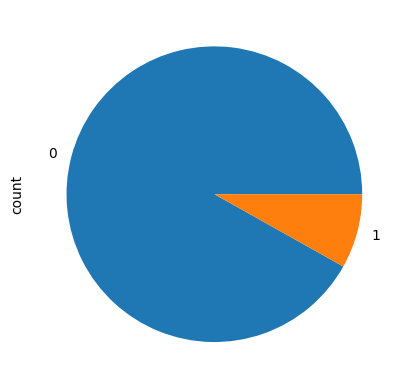

In [42]:
# lets find out churn/non churn percentage
print((telecom_filtered['churn'].value_counts()/len(telecom))*100)
((telecom_filtered['churn'].value_counts()/len(telecom))*100).plot(kind="pie")
plt.show()

##### As we can see that 97% of the customers do not churn, there is a possibility of class imbalance

Since this variable churn is the target variable, all the columns relating to this variable(i.e. all columns with suffix _9) can be dropped forn the dataset.

In [43]:
# Selecting all the churn phase columns in order to drop then

telecom_phase_cols = [col for col in telecom_filtered.columns if '_9' in col]
print("The columns from churn phase are:\n",telecom_phase_cols)

The columns from churn phase are:
 ['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'last_day_rch_amt_9', 'total_rech_data_9', 'max_rech_data_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9']


In [44]:
# Dropping the selected churn phase columns
telecom_filtered.drop(telecom_phase_cols, axis=1, inplace=True)

# The curent dimension of the dataset after dropping the churn related columns
telecom_filtered.shape

(30001, 152)

We can still clean the data by few possible columns relating to the good phase.

As we derived few columns in the good phase earlier, we can drop those related columns during creation.

In [45]:
telecom_filtered.drop(['av_rech_amt_data_6',
                   'total_rech_data_6','total_rech_amt_6',
                  'av_rech_amt_data_7',
                   'total_rech_data_7','total_rech_amt_7'], axis=1, inplace=True)


We can also create new columns to define the variables for the good phase and then remove the separate variables for the 6th and 7th months.

Before addressing the handling of any remaining missing values, let's examine the collinearity among the independent variables to understand their dependencies.

In [46]:
# creating a list of column names for each month
mon_6_cols = [col for col in telecom_filtered.columns if '_6' in col]
mon_7_cols = [col for col in telecom_filtered.columns if '_7' in col]
mon_8_cols = [col for col in telecom_filtered.columns if '_8' in col]

In [47]:
# lets check the correlation amongst the independent variables, drop the highly correlated ones
telecom_corr = telecom_filtered.corr()
telecom_corr.loc[:,:] = np.tril(telecom_corr, k=-1)
telecom_corr = telecom_corr.stack()
telecom_corr
telecom_corr[(telecom_corr > 0.80) | (telecom_corr < -0.80)].sort_values(ascending=False)

fb_user_6           night_pck_user_6     0.956620
fb_user_7           night_pck_user_7     0.956322
total_rech_amt_8    arpu_8               0.955351
fb_user_8           night_pck_user_8     0.954831
isd_og_mou_8        isd_og_mou_7         0.943120
                    isd_og_mou_6         0.918187
isd_og_mou_7        isd_og_mou_6         0.915247
sachet_2g_8         total_rech_data_8    0.900629
total_ic_mou_6      loc_ic_mou_6         0.895069
total_ic_mou_8      loc_ic_mou_8         0.893149
total_ic_mou_7      loc_ic_mou_7         0.883005
std_og_t2t_mou_8    onnet_mou_8          0.860771
std_og_t2t_mou_7    onnet_mou_7          0.860381
std_og_t2t_mou_6    onnet_mou_6          0.859471
std_og_t2m_mou_7    offnet_mou_7         0.855018
std_og_t2m_mou_8    offnet_mou_8         0.851995
total_og_mou_8      std_og_mou_8         0.851063
total_og_mou_7      std_og_mou_7         0.849570
loc_ic_mou_8        loc_ic_t2m_mou_8     0.846955
std_ic_mou_8        std_ic_t2m_mou_8     0.845795


In [48]:
col_to_drop=['fb_user_6','fb_user_7','fb_user_8','total_rech_amt_8','isd_og_mou_8',
             'sachet_2g_8','isd_og_mou_8','total_ic_mou_6','total_ic_mou_8','total_ic_mou_7',               
               'std_og_t2t_mou_8','std_og_t2t_mou_7','total_og_mou_8','std_og_t2m_mou_8' ,'total_og_mou_7',
             'std_ic_mou_8','std_og_t2t_mou_6' ,'std_og_t2m_mou_7','std_ic_mou_7',]

# These columns can be dropped as they are highly collinered with other predictor variables.
# criteria set is for collinearity of 85%

#  dropping these column
telecom_filtered.drop(col_to_drop, axis=1, inplace=True)

In [49]:
# The curent dimension of the dataset after dropping few unwanted columns
telecom_filtered.shape

(30001, 128)

## Data preparation

#### Deriving new variables to understand the data

## EDA

In [50]:
# We have a column called 'aon'

# we can derive new variables from this to explain the data w.r.t churn.

# creating a new variable 'tenure'
telecom_filtered['tenure'] = (telecom_filtered['aon']/30).round(0)

# Since we derived a new column from 'aon', we can drop it
telecom_filtered.drop('aon',axis=1, inplace=True)

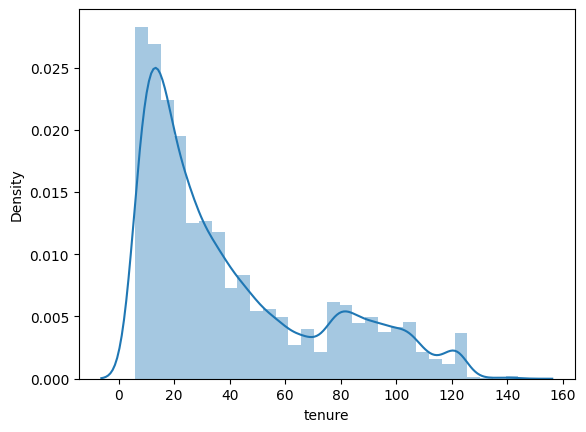

In [51]:
# Checking the distribution of he tenure variable

sns.distplot(telecom_filtered['tenure'],bins=30)
plt.show()

In [52]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
telecom_filtered['tenure_range'] = pd.cut(telecom_filtered['tenure'], tn_range, labels=tn_label)
telecom_filtered['tenure_range'].head()

0        2-5 Yrs
1        2-5 Yrs
2    6-12 Months
3        1-2 Yrs
4        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

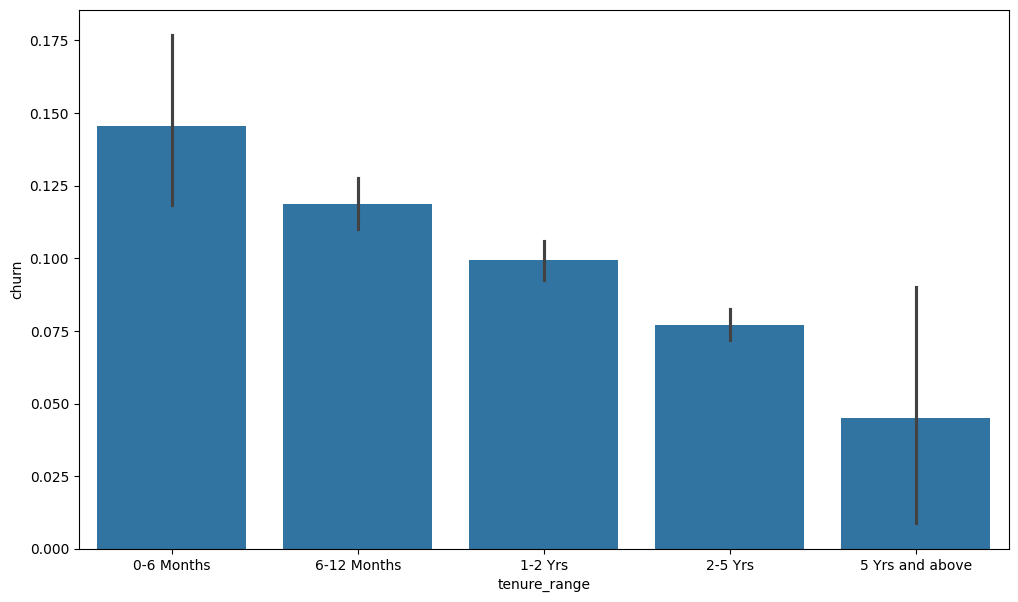

In [53]:
# Plotting a bar plot for tenure range
plt.figure(figsize=[12,7])
sns.barplot(x='tenure_range',y='churn', data=telecom_filtered)
plt.show()

It is observed that the highest churn rate occurs within the first 0-6 months, but it gradually decreases as the customer remains in the network.

The average revenue per user during the good phase is represented by arpu_6 and arpu_7. To simplify, we can calculate the average of these two values and then drop the individual columns.

In [54]:
telecom_filtered["avg_arpu_6_7"]= (telecom_filtered['arpu_6']+telecom_filtered['arpu_7'])/2
telecom_filtered['avg_arpu_6_7'].head()

0     206.1005
1    1209.5150
2     435.4720
3     556.1030
4     134.1235
Name: avg_arpu_6_7, dtype: float64

In [55]:
# Lets drop the original columns as they are derived to a new column for better understanding of the data

telecom_filtered.drop(['arpu_6','arpu_7'], axis=1, inplace=True)


# The curent dimension of the dataset after dropping few unwanted columns
telecom_filtered.shape

(30001, 128)

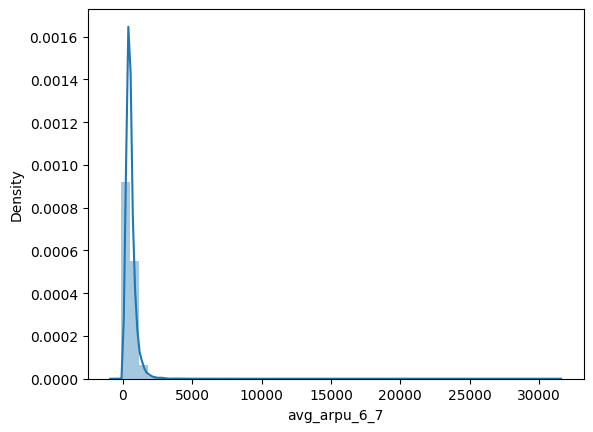

In [56]:
# Visualizing the column created
sns.distplot(telecom_filtered['avg_arpu_6_7'])
plt.show()

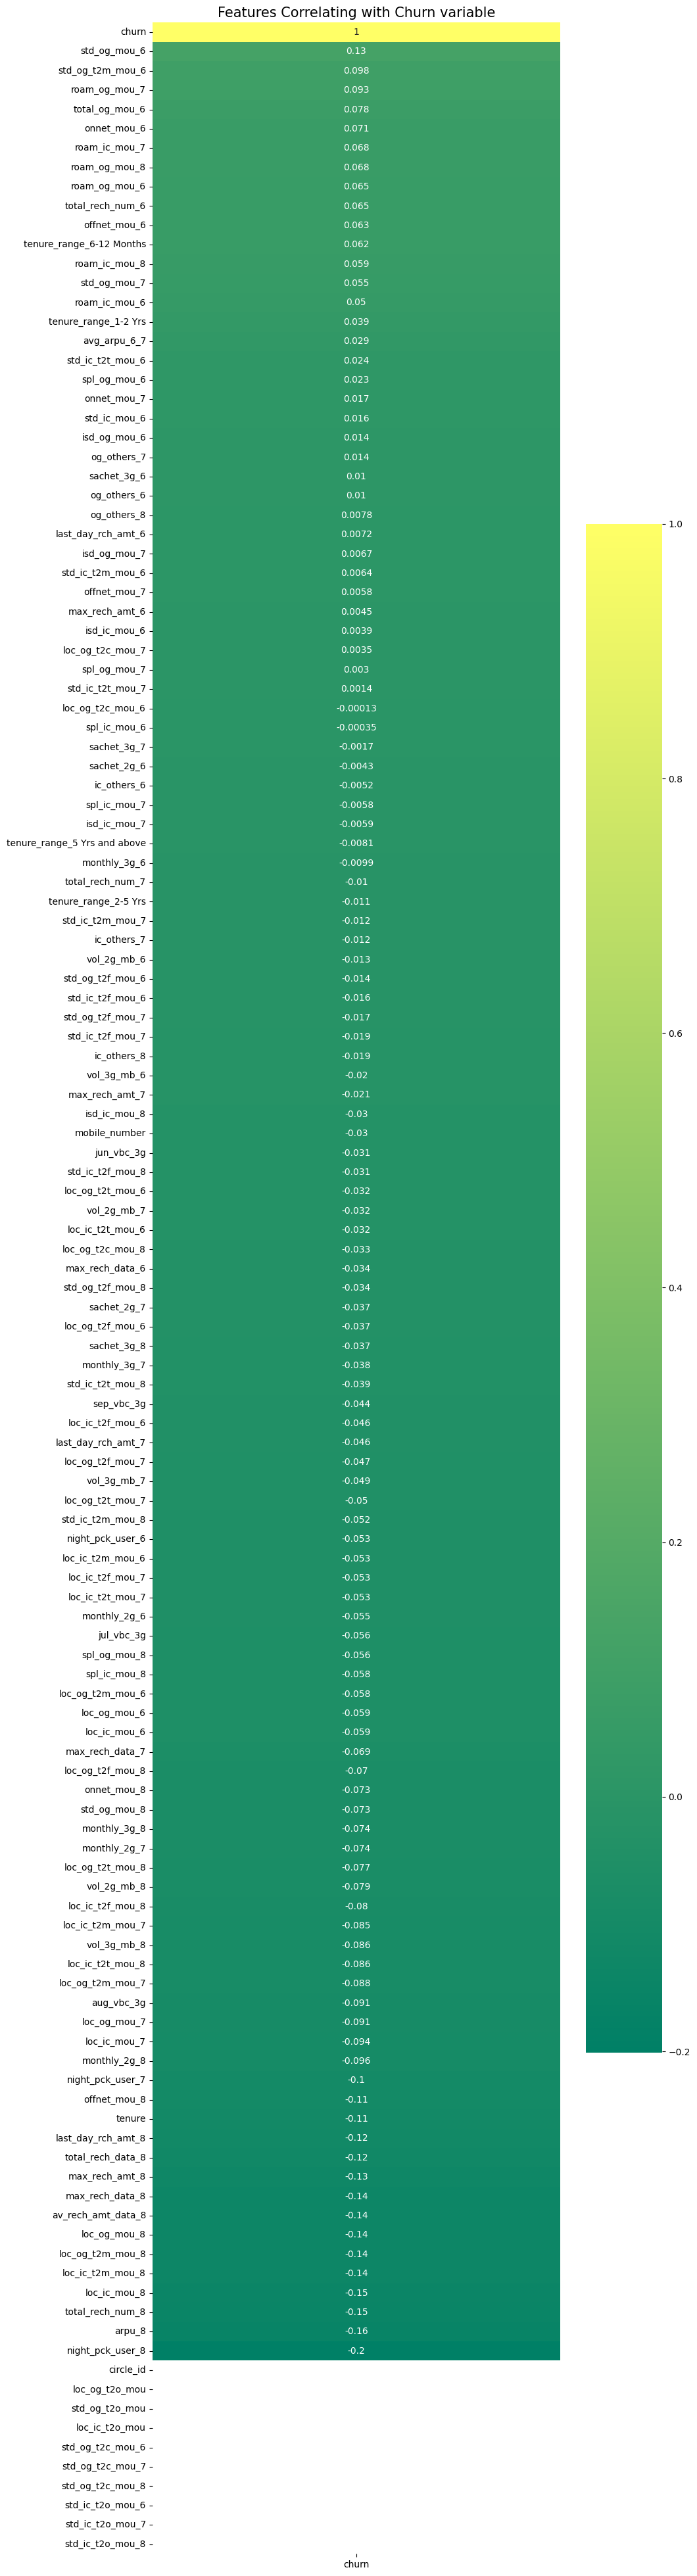

In [57]:
# Assuming telecom_filtered is your DataFrame
# Convert categorical columns to numeric using one-hot encoding
telecom_filtered_numeric = pd.get_dummies(telecom_filtered, drop_first=True)

# Compute the correlation matrix
correlation_matrix = telecom_filtered_numeric.corr()

# Plot the heatmap for the target variable 'churn'
plt.figure(figsize=(10, 50))
heatmap_churn = sns.heatmap(correlation_matrix[['churn']].sort_values(by='churn', ascending=False), annot=True, cmap='summer')
heatmap_churn.set_title("Features Correlating with Churn variable", fontsize=15)
plt.show()


The average number of outgoing calls and calls during roaming in the 6th and 7th months are positively correlated with churn.

The average revenue and the number of recharges in the 8th month are negatively correlated with churn.

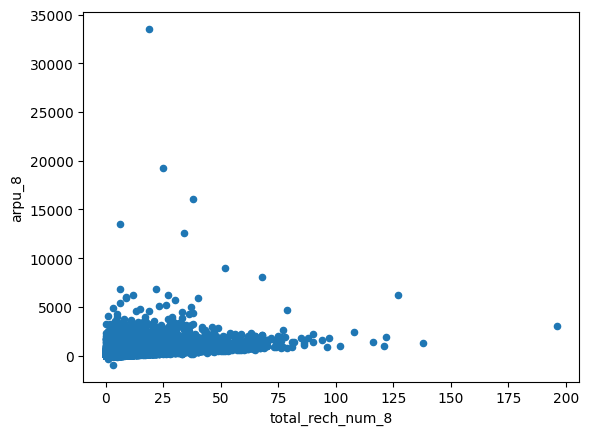

In [58]:
# lets now draw a scatter plot between total recharge and avg revenue for the 8th month
telecom_filtered[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8', y='arpu_8')
plt.show()

In [59]:
# Creating categories for month 8 column totalrecharge and their count
telecom_filtered['total_rech_data_group_8']=pd.cut(telecom_filtered['total_rech_data_8'],[-1,0,10,25,100],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])
telecom_filtered['total_rech_num_group_8']=pd.cut(telecom_filtered['total_rech_num_8'],[-1,0,10,25,1000],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])

					Distribution of total_rech_data_8 variable
 total_rech_data_group_8
<=10_Recharges     15307
No_Recharge        14048
10-25_Recharges      608
>25_Recharges         38
Name: count, dtype: int64


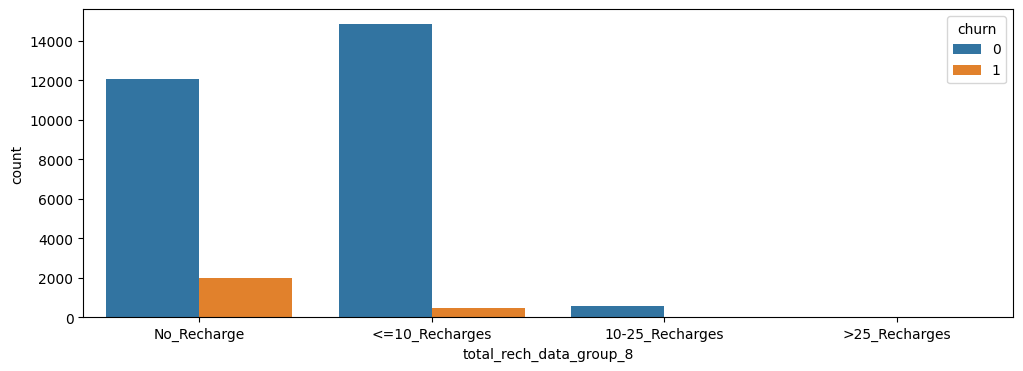

					Distribution of total_rech_num_8 variable
 total_rech_num_group_8
<=10_Recharges     19349
10-25_Recharges     8245
>25_Recharges       1824
No_Recharge          583
Name: count, dtype: int64


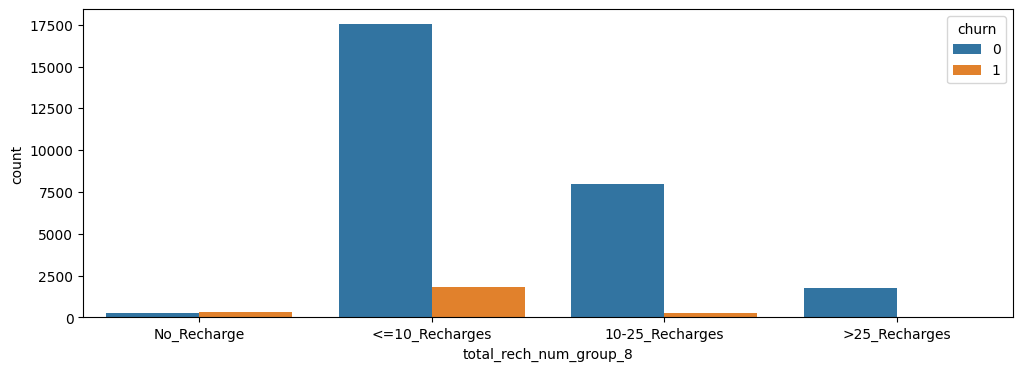

In [60]:
# Plotting the results

plt.figure(figsize=[12,4])
sns.countplot(data=telecom_filtered,x="total_rech_data_group_8",hue="churn")
print("\t\t\t\t\tDistribution of total_rech_data_8 variable\n",telecom_filtered['total_rech_data_group_8'].value_counts())
plt.show()
plt.figure(figsize=[12,4])
sns.countplot(data=telecom_filtered,x="total_rech_num_group_8",hue="churn")
print("\t\t\t\t\tDistribution of total_rech_num_8 variable\n",telecom_filtered['total_rech_num_group_8'].value_counts())
plt.show()

As the number of recharges increases, the churn rate clearly decreases.

In [61]:
telecom_filtered.drop(['av_rech_amt_data_8','total_rech_data_8','sachet_2g_6','sachet_2g_7','sachet_3g_6',
              'sachet_3g_7','sachet_3g_8','last_day_rch_amt_6','last_day_rch_amt_7',
              'last_day_rch_amt_8',], axis=1, inplace=True)

We can now drop all "mou-related" columns except for the onnet and offnet variables.

In [62]:
telecom_filtered.drop(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou','roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 
         'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
         'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
         'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 
         'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7',
         'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'spl_og_mou_6',
         'spl_og_mou_7', 'spl_og_mou_8','total_og_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 
         'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8',
         'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 
         'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8',
         'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_mou_6', 'spl_ic_mou_6', 'spl_ic_mou_7',
         'spl_ic_mou_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8',], axis=1, inplace=True)

In [63]:
telecom_filtered.shape

(30001, 49)

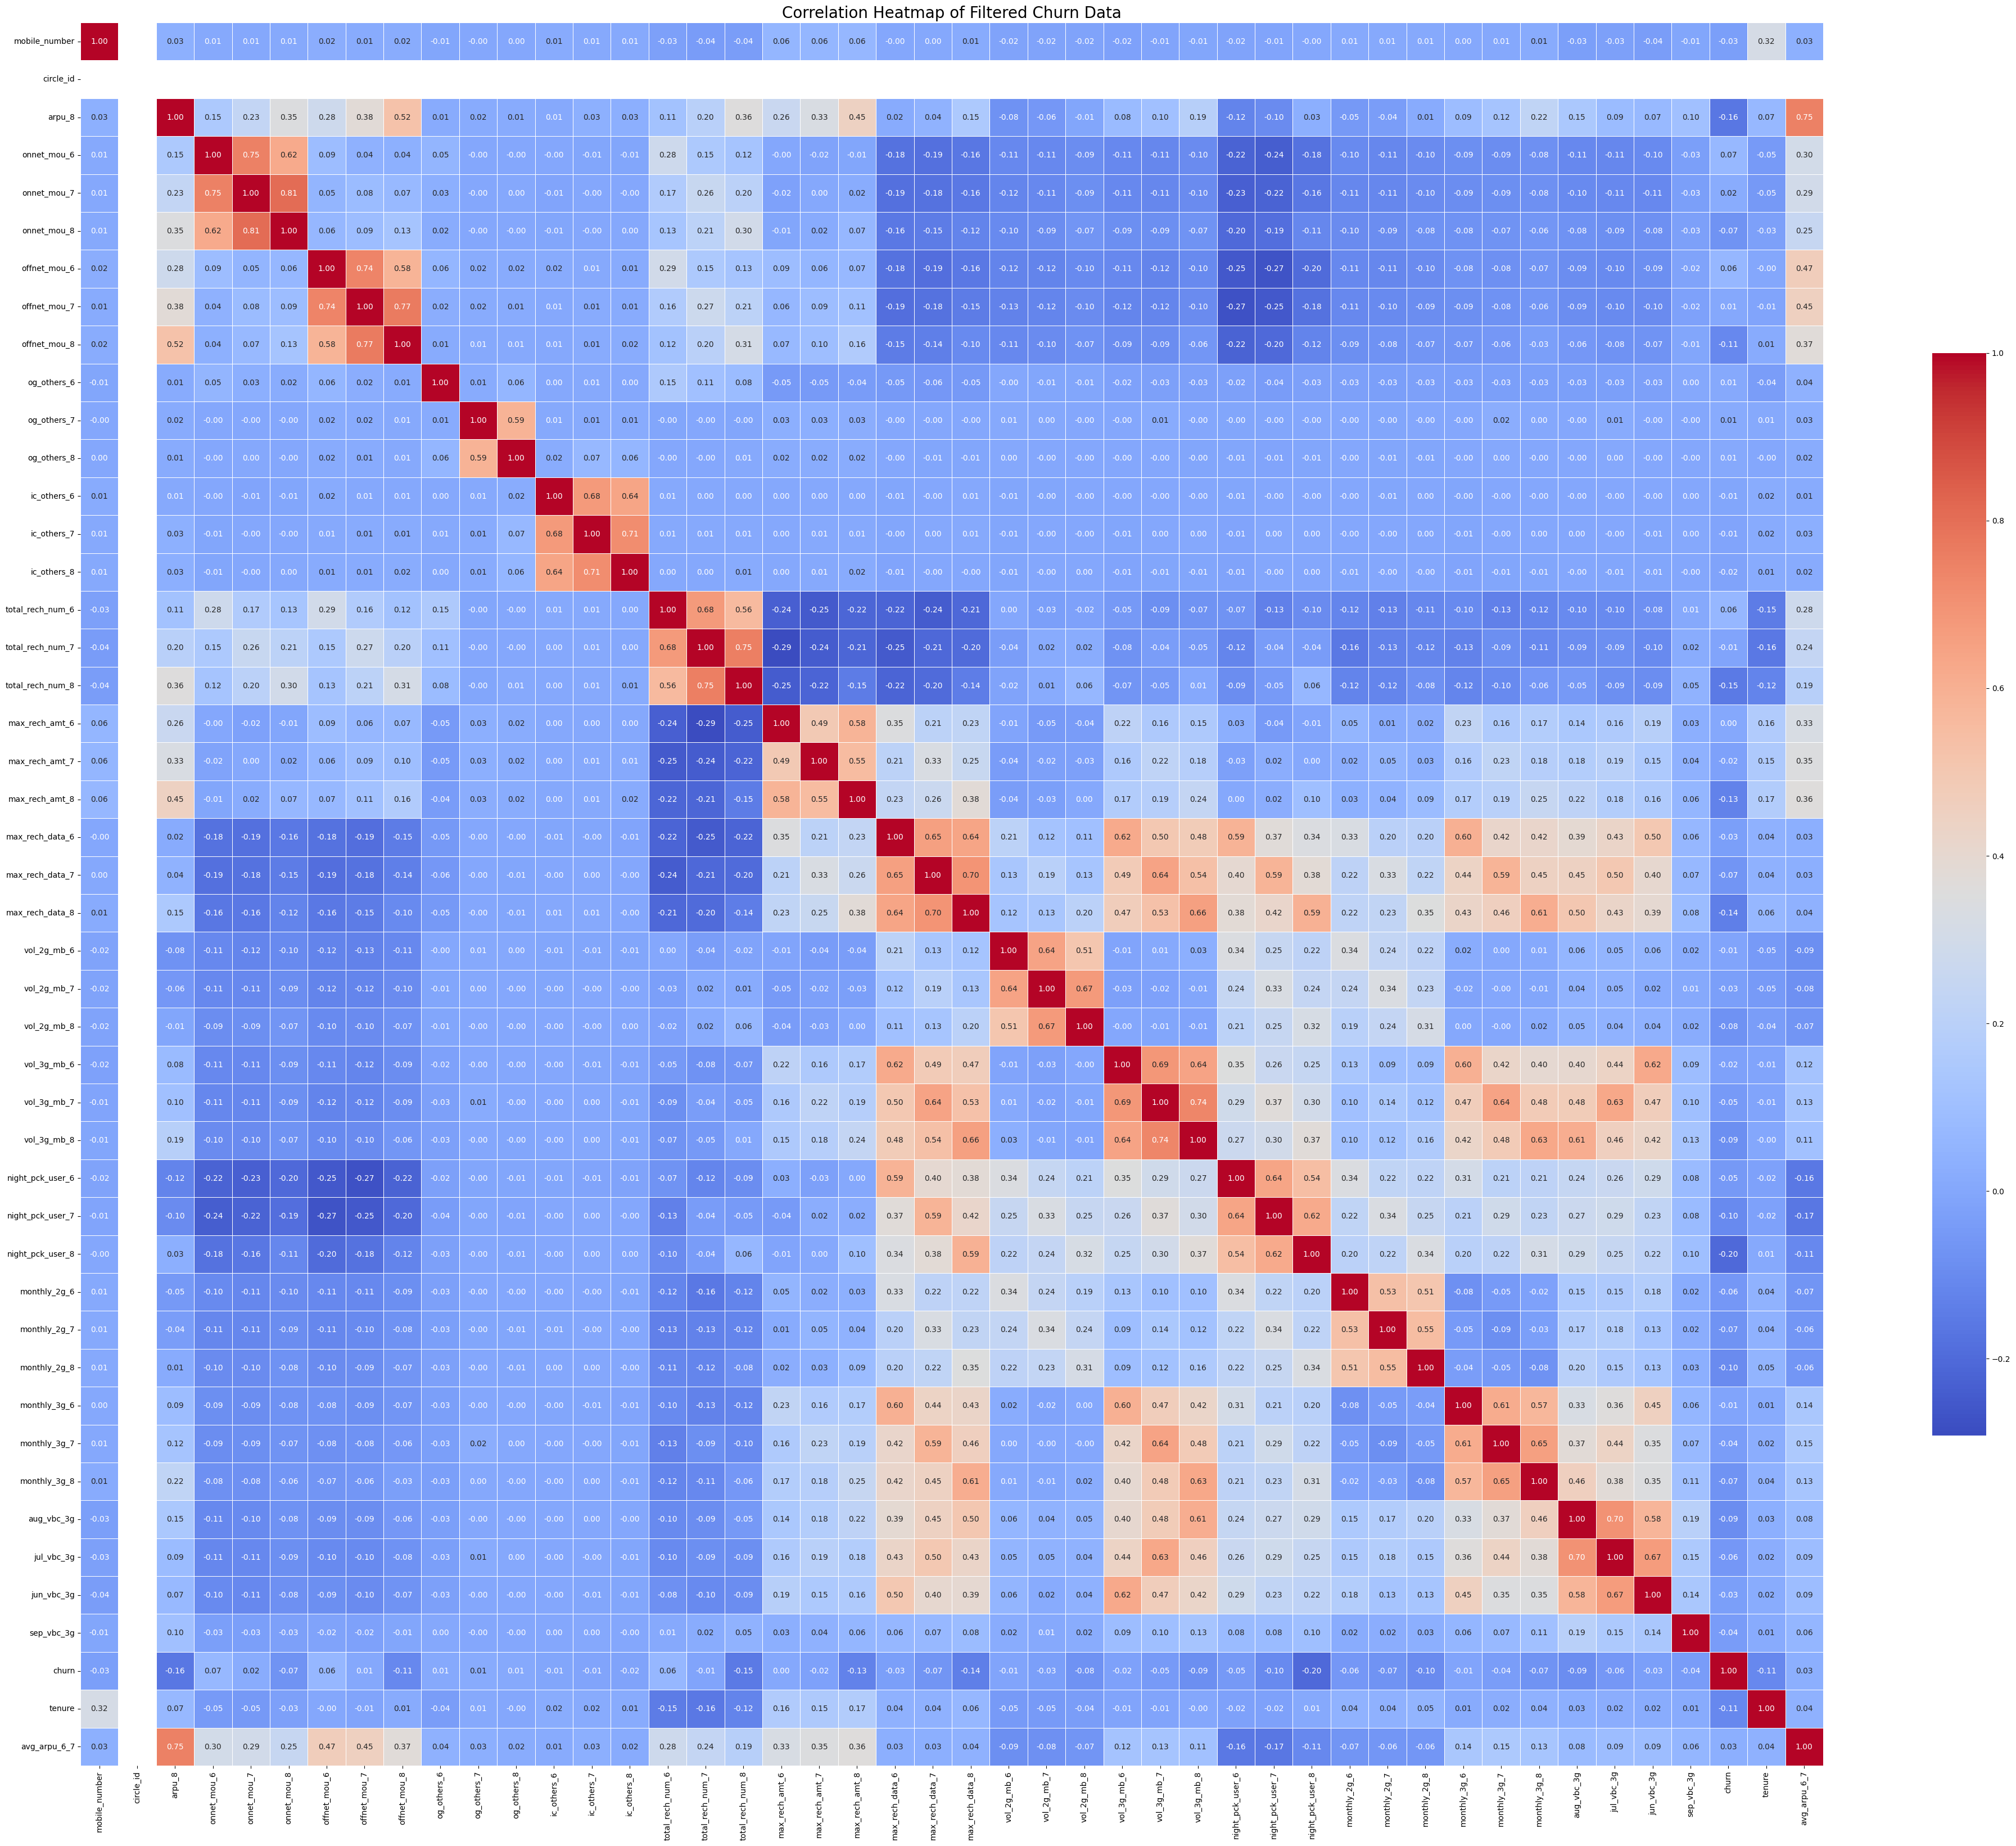

In [64]:
# Identify non-numeric columns
non_numeric_columns = telecom_filtered.select_dtypes(exclude=[float, int]).columns

# Drop non-numeric columns (if not needed)
telecom_filtered_numeric = telecom_filtered.drop(columns=non_numeric_columns)

# Alternatively, if some non-numeric columns are needed, convert them appropriately
# Compute the correlation matrix
plt.figure(figsize=(50, 50))
heatmap = sns.heatmap(telecom_filtered_numeric.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5, cbar_kws={"shrink": .5})
heatmap.set_title('Correlation Heatmap of Filtered Churn Data', fontsize=20)
plt.show()


In [65]:
# info
telecom_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30001 entries, 0 to 30000
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   mobile_number            30001 non-null  int64   
 1   circle_id                30001 non-null  int64   
 2   arpu_8                   30001 non-null  float64 
 3   onnet_mou_6              30001 non-null  float64 
 4   onnet_mou_7              30001 non-null  float64 
 5   onnet_mou_8              30001 non-null  float64 
 6   offnet_mou_6             30001 non-null  float64 
 7   offnet_mou_7             30001 non-null  float64 
 8   offnet_mou_8             30001 non-null  float64 
 9   og_others_6              30001 non-null  float64 
 10  og_others_7              30001 non-null  float64 
 11  og_others_8              30001 non-null  float64 
 12  ic_others_6              30001 non-null  float64 
 13  ic_others_7              30001 non-null  float64 
 14  ic_oth

In [66]:
# Dropping all category columns
telecom_filtered.drop(['total_rech_data_group_8','total_rech_num_group_8', 'tenure_range'] , axis=1, inplace=True)

In [67]:
telecom_rate = (sum(telecom_filtered["churn"])/len(telecom_filtered["churn"].index))*100
telecom_rate

8.136395453484884

## Split Data Into Train and Test Data

In [68]:
telecom_filtered.shape

(30001, 46)

In [69]:
from sklearn.model_selection import train_test_split

# divide data into train and test
X = telecom_filtered.drop("churn", axis = 1)
y = telecom_filtered.churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4, stratify = y)

In [70]:
# print shapes of train and test sets
X_train.shape

(21000, 45)

In [71]:
y_train.shape

(21000,)

In [72]:
X_test.shape

(9001, 45)

In [73]:
y_test.shape

(9001,)

## Performe Scaling

In [74]:
X_train.head()

,mobile_number,circle_id,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,og_others_6,og_others_7,og_others_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,tenure,avg_arpu_6_7
28122,7002263503,109,707.000,106.56,118.03,25.44,396.89,418.78,364.43,0.00,0.0,0.0,0.0,0.0,0.0,8,7,5,250,550,250,0.0,0.0,152.0,0.00,0.00,6.73,0.00,0.00,125.71,-1.0,-1.0,0.0,0,0,0,0,0,0,60.74,198.51,22.72,0.0,76.0,1061.3290
22066,7000838880,109,238.434,4.23,5.34,5.48,47.93,48.99,58.49,0.00,0.0,0.0,0.0,0.0,0.0,4,4,3,154,152,152,154.0,152.0,152.0,358.36,13.07,2.71,0.00,589.83,616.13,0.0,0.0,0.0,1,0,0,0,0,0,36.49,251.32,0.00,0.0,13.0,182.8475
10150,7002222866,109,141.514,0.00,0.00,0.00,53.03,7.93,6.71,0.00,0.0,0.0,0.0,0.0,0.0,9,16,13,91,91,25,91.0,91.0,25.0,0.00,0.00,0.02,448.67,711.54,598.83,0.0,0.0,0.0,0,0,0,0,0,0,0.00,0.00,0.00,0.0,15.0,237.7630
26262,7000415671,109,0.550,678.43,165.04,0.00,497.04,322.18,0.40,0.00,0.0,0.0,0.0,0.0,0.0,22,10,4,50,110,0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,-1.0,-1.0,-1.0,0,0,0,0,0,0,0.00,0.00,0.00,0.0,22.0,567.6350
5320,7001717987,109,820.655,1208.24,1380.31,1310.78,245.46,782.89,478.08,11.03,0.0,0.0,0.0,0.0,0.0,41,31,16,67,110,150,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,-1.0,-1.0,-1.0,0,0,0,0,0,0,0.00,0.00,0.00,0.0,10.0,935.7090


In [75]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21000 entries, 28122 to 22754
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mobile_number     21000 non-null  int64  
 1   circle_id         21000 non-null  int64  
 2   arpu_8            21000 non-null  float64
 3   onnet_mou_6       21000 non-null  float64
 4   onnet_mou_7       21000 non-null  float64
 5   onnet_mou_8       21000 non-null  float64
 6   offnet_mou_6      21000 non-null  float64
 7   offnet_mou_7      21000 non-null  float64
 8   offnet_mou_8      21000 non-null  float64
 9   og_others_6       21000 non-null  float64
 10  og_others_7       21000 non-null  float64
 11  og_others_8       21000 non-null  float64
 12  ic_others_6       21000 non-null  float64
 13  ic_others_7       21000 non-null  float64
 14  ic_others_8       21000 non-null  float64
 15  total_rech_num_6  21000 non-null  int64  
 16  total_rech_num_7  21000 non-null  int64  

In [76]:
num_col = X_train.select_dtypes(include = ['int64','float64']).columns.tolist()

In [77]:
# apply scaling on the dataset
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train[num_col] = scaler.fit_transform(X_train[num_col])

In [78]:
X_train.head()

,mobile_number,circle_id,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,og_others_6,og_others_7,og_others_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,tenure,avg_arpu_6_7
28122,0.938859,0.0,0.047922,0.015199,0.015926,0.003546,0.057004,0.043320,0.026017,0.000000,0.0,0.0,0.0,0.0,0.0,0.026059,0.050725,0.025510,0.070244,0.137157,0.056192,0.000000,0.000000,0.097749,0.00000,0.00000,0.000605,0.00000,0.000000,0.004185,0.0,0.0,0.5,0.00,0.0,0.0,0.0,0.0,0.0,0.004703,0.021658,0.002035,0.0,0.507246,0.056266
22066,0.347933,0.0,0.034336,0.000603,0.000721,0.000764,0.006884,0.005068,0.004176,0.000000,0.0,0.0,0.0,0.0,0.0,0.013029,0.028986,0.015306,0.043271,0.037905,0.034165,0.099035,0.097749,0.097749,0.03484,0.00166,0.000244,0.00000,0.020957,0.020513,0.5,0.5,0.5,0.25,0.0,0.0,0.0,0.0,0.0,0.002825,0.027420,0.000000,0.0,0.050725,0.028974
10150,0.922003,0.0,0.031526,0.000000,0.000000,0.000000,0.007617,0.000820,0.000479,0.000000,0.0,0.0,0.0,0.0,0.0,0.029316,0.115942,0.066327,0.025569,0.022693,0.005619,0.058521,0.058521,0.016077,0.00000,0.00000,0.000002,0.00981,0.025282,0.019937,0.5,0.5,0.5,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.065217,0.030680
26262,0.172388,0.0,0.027439,0.096765,0.022270,0.000000,0.071389,0.033327,0.000029,0.000000,0.0,0.0,0.0,0.0,0.0,0.071661,0.072464,0.020408,0.014049,0.027431,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.115942,0.040929
5320,0.712582,0.0,0.051218,0.172332,0.186251,0.182698,0.035255,0.080985,0.034131,0.156432,0.0,0.0,0.0,0.0,0.0,0.133550,0.224638,0.081633,0.018826,0.027431,0.033715,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.028986,0.052364


As there are many variables, we will begin the process of dropping variables after performing Recursive Feature Elimination (RFE).

## Data Modeling, Model Evaluation, and Preparing the Model for Predictor Variable Selection

### Data Imbalance Handling

Using SMOTE method, we can balance the data w.r.t. churn variable and proceed further

In [79]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_sm,y_train_sm = sm.fit_resample(X_train,y_train)

In [80]:
print("Dimension of X_train_sm Shape:", X_train_sm.shape)
print("Dimension of y_train_sm Shape:", y_train_sm.shape)

Dimension of X_train_sm Shape: (38582, 45)
Dimension of y_train_sm Shape: (38582,)


## Logistic Regression

In [81]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

from sklearn.feature_selection import RFE

# running RFE with 20 variables as output
rfe = RFE(logreg,  n_features_to_select= 20)             
rfe = rfe.fit(X_train_sm, y_train_sm)

In [82]:
rfe.support_

array([False, False,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False,  True,  True,  True,  True,
       False, False,  True, False, False, False, False, False,  True,
       False, False,  True, False, False, False, False, False,  True,
        True, False,  True,  True, False, False,  True, False,  True])

In [83]:
rfe_columns=X_train_sm.columns[rfe.support_]
print("The selected columns by RFE for modelling are: \n\n",rfe_columns)

The selected columns by RFE for modelling are: 

 Index(['arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'ic_others_8', 'total_rech_num_6',
       'total_rech_num_7', 'total_rech_num_8', 'max_rech_amt_8', 'vol_2g_mb_8',
       'vol_3g_mb_8', 'monthly_2g_8', 'monthly_3g_6', 'monthly_3g_8',
       'aug_vbc_3g', 'sep_vbc_3g', 'avg_arpu_6_7'],
      dtype='object')


In [84]:
list(zip(X_train_sm.columns, rfe.support_, rfe.ranking_))

[('mobile_number', False, 24),
 ('circle_id', False, 26),
 ('arpu_8', True, 1),
 ('onnet_mou_6', True, 1),
 ('onnet_mou_7', True, 1),
 ('onnet_mou_8', True, 1),
 ('offnet_mou_6', True, 1),
 ('offnet_mou_7', True, 1),
 ('offnet_mou_8', True, 1),
 ('og_others_6', False, 2),
 ('og_others_7', False, 20),
 ('og_others_8', False, 22),
 ('ic_others_6', False, 11),
 ('ic_others_7', False, 16),
 ('ic_others_8', True, 1),
 ('total_rech_num_6', True, 1),
 ('total_rech_num_7', True, 1),
 ('total_rech_num_8', True, 1),
 ('max_rech_amt_6', False, 12),
 ('max_rech_amt_7', False, 3),
 ('max_rech_amt_8', True, 1),
 ('max_rech_data_6', False, 13),
 ('max_rech_data_7', False, 17),
 ('max_rech_data_8', False, 18),
 ('vol_2g_mb_6', False, 14),
 ('vol_2g_mb_7', False, 8),
 ('vol_2g_mb_8', True, 1),
 ('vol_3g_mb_6', False, 5),
 ('vol_3g_mb_7', False, 9),
 ('vol_3g_mb_8', True, 1),
 ('night_pck_user_6', False, 25),
 ('night_pck_user_7', False, 21),
 ('night_pck_user_8', False, 10),
 ('monthly_2g_6', False, 15

# Assessing the model with StatsModels

In [85]:
import statsmodels.api as sm

# Ensure X_train_sm and rfe_columns are defined correctly
X_train_SM = sm.add_constant(X_train_sm[rfe_columns])

# Proceed with creating the GLM model
logm2 = sm.GLM(y_train_sm, X_train_SM, family=sm.families.Binomial())
res = logm2.fit()


In [86]:
# Getting the predicted values on the train set
y_train_sm_pred = res.predict(X_train_SM)
y_train_sm_pred = y_train_sm_pred.values.reshape(-1)
y_train_sm_pred[:10]

array([0.57287848, 0.51492255, 0.47686568, 0.87442303, 0.45066605,
       0.26331504, 0.05819709, 0.29910444, 0.03125975, 0.14344923])

# Creating a dataframe with the actual churn flag and the predicted probabilities

In [87]:
y_train_sm_pred_final = pd.DataFrame({'Converted':y_train_sm.values, 'Converted_prob':y_train_sm_pred})
y_train_sm_pred_final.head()

,Converted,Converted_prob
0,0,0.572878
1,0,0.514923
2,0,0.476866
3,0,0.874423
4,0,0.450666


### Creating new column 'churn_pred' with 1 if Churn_Prob > 0.8 else 0

In [88]:
y_train_sm_pred_final['churn_pred'] = y_train_sm_pred_final.Converted_prob.map(lambda x: 1 if x > 0.5 else 0)

# Viewing the prediction results
y_train_sm_pred_final.head()

,Converted,Converted_prob,churn_pred
0,0,0.572878,1
1,0,0.514923,1
2,0,0.476866,0
3,0,0.874423,1
4,0,0.450666,0


In [89]:
from sklearn import metrics

# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final.churn_pred )
print(confusion)

[[14950  4341]
 [ 3631 15660]]


In [90]:
# Checking the overall accuracy.
print("The overall accuracy of the model is:",metrics.accuracy_score(y_train_sm_pred_final.Converted, y_train_sm_pred_final.churn_pred))

The overall accuracy of the model is: 0.7933751490332279


# Check for the VIF values of the feature variables

In [91]:
 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [92]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_sm[rfe_columns].columns
vif['VIF'] = [variance_inflation_factor(X_train_sm[rfe_columns].values, i) for i in range(X_train_sm[rfe_columns].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
19,avg_arpu_6_7,41.58
0,arpu_8,41.00
9,total_rech_num_7,8.60
8,total_rech_num_6,6.56
5,offnet_mou_7,6.19
10,total_rech_num_8,5.50
2,onnet_mou_7,5.29
4,offnet_mou_6,4.58
6,offnet_mou_8,4.06
1,onnet_mou_6,3.70


## Metrics beyond simply accuracy

In [93]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [94]:
# Let's see the sensitivity of our logistic regression model
print("Sensitivity = ",TP / float(TP+FN))

# Let us calculate specificity
print("Specificity = ",TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print("False Positive Rate = ",FP/ float(TN+FP))

# positive predictive value 
print ("Precision = ",TP / float(TP+FP))

# Negative predictive value
print ("True Negative Prediction Rate = ",TN / float(TN+ FN))

Sensitivity =  0.811777512829817
Specificity =  0.7749727852366388
False Positive Rate =  0.22502721476336116
Precision =  0.7829608519574022
True Negative Prediction Rate =  0.8045853290996179


#### Plotting the ROC Curve

In [95]:
# Defining a function to plot the roc curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Prediction Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [96]:
# Defining the variables to plot the curve
fpr, tpr, thresholds = metrics.roc_curve( y_train_sm_pred_final.Converted, y_train_sm_pred_final.Converted_prob, drop_intermediate = False )

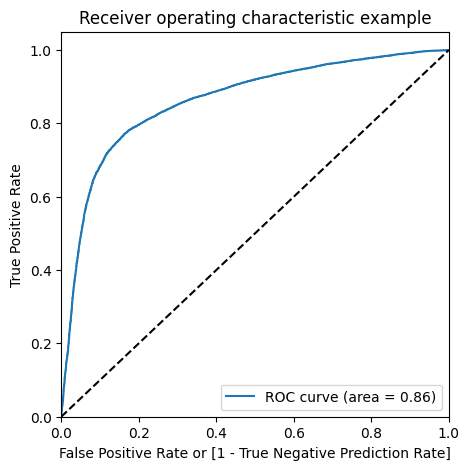

In [97]:
# Plotting the curve for the obtained metrics
draw_roc(y_train_sm_pred_final.Converted, y_train_sm_pred_final.Converted_prob)

#### Finding Optimal Cutoff Point

In [98]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_sm_pred_final[i]= y_train_sm_pred_final.Converted_prob.map(lambda x: 1 if x > i else 0)
y_train_sm_pred_final.head()

,Converted,Converted_prob,churn_pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.572878,1,1,1,1,1,1,1,0,0,0,0
1,0,0.514923,1,1,1,1,1,1,1,0,0,0,0
2,0,0.476866,0,1,1,1,1,1,0,0,0,0,0
3,0,0.874423,1,1,1,1,1,1,1,1,1,1,0
4,0,0.450666,0,1,1,1,1,1,0,0,0,0,0


In [99]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['probability','accuracy','sensitivity','specificity'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensitivity,specificity]
print(cutoff_df)

     probability  accuracy  sensitivity  specificity
0.0          0.0  0.500000     1.000000     0.000000
0.1          0.1  0.608185     0.972682     0.243689
0.2          0.2  0.671038     0.943756     0.398320
0.3          0.3  0.721917     0.910010     0.533824
0.4          0.4  0.764813     0.868177     0.661448
0.5          0.5  0.793375     0.811778     0.774973
0.6          0.6  0.802136     0.741900     0.862371
0.7          0.7  0.773495     0.623555     0.923436
0.8          0.8  0.677414     0.391996     0.962832
0.9          0.9  0.558291     0.128039     0.988544


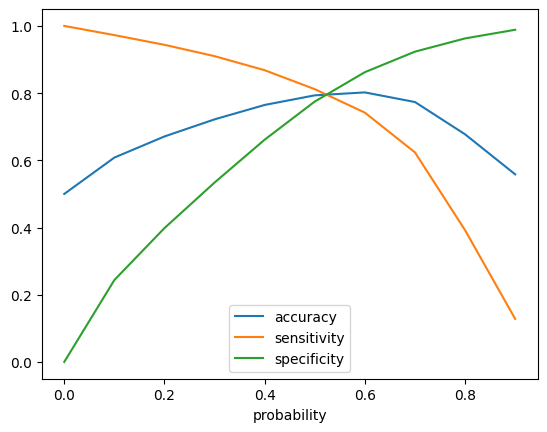

In [100]:
# plotting accuracy sensitivity and specificity for various probabilities calculated above.
cutoff_df.plot.line(x='probability', y=['accuracy','sensitivity','specificity'])
plt.show()

**Initially we selected the optimm point of classification as 0.5.<br><br>From the above graph, we can see the optimum cutoff is slightly higher than 0.5 but lies lower than 0.6. So lets tweek a little more within this range.**

In [101]:
# Let's create columns with refined probability cutoffs 
numbers = [0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59]
for i in numbers:
    y_train_sm_pred_final[i]= y_train_sm_pred_final.Converted_prob.map(lambda x: 1 if x > i else 0)
y_train_sm_pred_final.head()

,Converted,Converted_prob,churn_pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59
0,0,0.572878,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,1,0,0
1,0,0.514923,1,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0.476866,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0.874423,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
4,0,0.450666,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [102]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['probability','accuracy','sensitivity','specificity'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensitivity,specificity]
print(cutoff_df)

      probability  accuracy  sensitivity  specificity
0.50         0.50  0.793375     0.811778     0.774973
0.51         0.51  0.795345     0.805401     0.785288
0.52         0.52  0.797289     0.798922     0.795656
0.53         0.53  0.799181     0.792701     0.805661
0.54         0.54  0.801643     0.787984     0.815302
0.55         0.55  0.802991     0.781660     0.824322
0.56         0.56  0.803432     0.774403     0.832461
0.57         0.57  0.803354     0.765953     0.840755
0.58         0.58  0.802836     0.758177     0.847494
0.59         0.59  0.802680     0.749935     0.855425


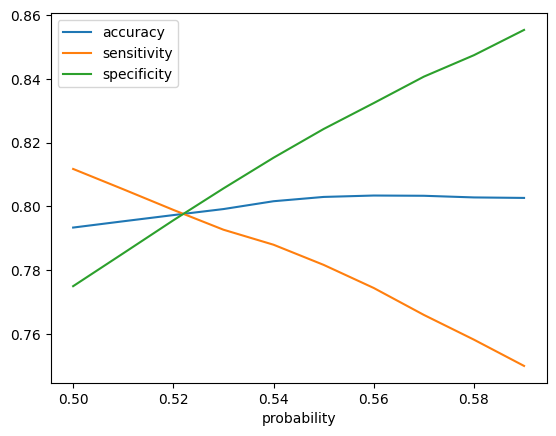

In [103]:
# plotting accuracy sensitivity and specificity for various probabilities calculated above.
cutoff_df.plot.line(x='probability', y=['accuracy','sensitivity','specificity'])
plt.show()

**From the above graph we can conclude, the optimal cutoff point in the probability to define the predicted churn variabe converges at `0.53`**

In [104]:
#### From the curve above,we can take 0.53 is the optimum point to take it as a cutoff probability.

y_train_sm_pred_final['final_churn_pred'] = y_train_sm_pred_final.Converted_prob.map( lambda x: 1 if x > 0.53 else 0)

y_train_sm_pred_final.head()

,Converted,Converted_prob,churn_pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,final_churn_pred
0,0,0.572878,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,1,0,0,1
1,0,0.514923,1,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0.476866,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0.874423,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
4,0,0.450666,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [105]:
# Calculating the ovearall accuracy again
print("The overall accuracy of the model now is:",metrics.accuracy_score(y_train_sm_pred_final.Converted, y_train_sm_pred_final.final_churn_pred))

The overall accuracy of the model now is: 0.7991809652169406


In [106]:
confusion2 = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final.final_churn_pred )
print(confusion2)

[[15542  3749]
 [ 3999 15292]]


In [107]:
TP2 = confusion2[1,1] # true positive 
TN2 = confusion2[0,0] # true negatives
FP2 = confusion2[0,1] # false positives
FN2 = confusion2[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print("Sensitivity = ",TP2 / float(TP2+FN2))

# Let us calculate specificity
print("Specificity = ",TN2 / float(TN2+FP2))

# Calculate false postive rate - predicting churn when customer does not have churned
print("False Positive Rate = ",FP2/ float(TN2+FP2))

# positive predictive value 
print ("Precision = ",TP2 / float(TP2+FP2))

# Negative predictive value
print ("True Negative Prediction Rate = ",TN2 / float(TN2 + FN2))

Sensitivity =  0.7927012596547612
Specificity =  0.8056606707791198
False Positive Rate =  0.1943393292208802
Precision =  0.8031090804054409
True Negative Prediction Rate =  0.7953533596028862


#### Precision and recall tradeoff

In [108]:
from sklearn.metrics import precision_recall_curve

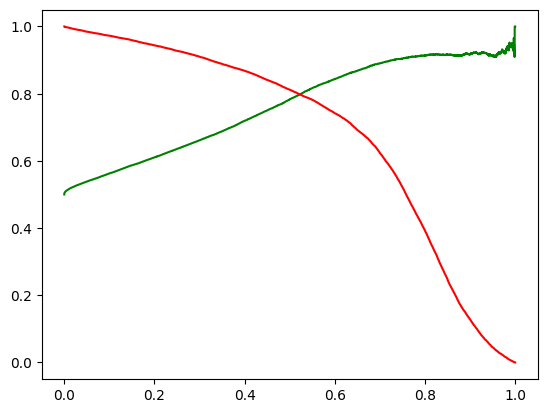

In [109]:
p, r, thresholds = precision_recall_curve(y_train_sm_pred_final.Converted, y_train_sm_pred_final.Converted_prob)

# Plotting the curve
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### Making predictions on the test set
**Transforming and feature selection for test data**

In [110]:
# Scaling the test data
X_test[num_col] = scaler.transform(X_test[num_col])
X_test.head()

,mobile_number,circle_id,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,og_others_6,og_others_7,og_others_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,tenure,avg_arpu_6_7
15721,0.543235,0.0,0.070951,0.092747,0.116778,0.160736,0.007750,0.004340,0.005453,0.020706,0.0,0.0,0.0,0.0,0.00000,0.058632,0.144928,0.086735,0.070806,0.062843,0.056642,0.162058,0.162058,0.162058,0.011062,0.012486,0.011916,0.03376,0.103343,0.094862,0.5,0.5,0.5,0.25,0.0,0.0,0.071429,0.1875,0.1875,0.10885,0.194395,0.126903,0.006211,0.021739,0.068080
4719,0.465401,0.0,0.050100,0.022912,0.026296,0.015456,0.083234,0.075125,0.039182,0.000000,0.0,0.0,0.0,0.0,0.00000,0.029316,0.057971,0.030612,0.070244,0.062344,0.056192,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0000,0.0000,0.00000,0.000000,0.000000,0.000000,0.282609,0.049281
9414,0.297412,0.0,0.037307,0.015232,0.014713,0.006200,0.064102,0.045187,0.019364,0.000000,0.0,0.0,0.0,0.0,0.00000,0.016287,0.057971,0.045918,0.030908,0.027431,0.011238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0000,0.0000,0.00000,0.000000,0.000000,0.000000,0.442029,0.036888
29717,0.962101,0.0,0.040508,0.129820,0.117567,0.119239,0.020095,0.019448,0.006933,0.000000,0.0,0.0,0.0,0.0,0.00000,0.026059,0.079710,0.051020,0.030908,0.031920,0.032367,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0000,0.0000,0.00000,0.000000,0.000000,0.000000,0.152174,0.038330
7841,0.080993,0.0,0.040732,0.000030,0.006323,0.005085,0.044734,0.041780,0.040840,0.000000,0.0,0.0,0.0,0.0,0.00424,0.013029,0.072464,0.005102,0.042147,0.124688,0.000000,0.026367,0.026367,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.5,0.5,0.0,0.00,0.0,0.0,0.000000,0.0000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.029264


In [111]:
# Feature selection
X_test=X_test[rfe_columns]
X_test.head()

,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_amt_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,monthly_3g_6,monthly_3g_8,aug_vbc_3g,sep_vbc_3g,avg_arpu_6_7
15721,0.070951,0.092747,0.116778,0.160736,0.007750,0.004340,0.005453,0.00000,0.058632,0.144928,0.086735,0.056642,0.011916,0.094862,0.0,0.071429,0.1875,0.10885,0.006211,0.068080
4719,0.050100,0.022912,0.026296,0.015456,0.083234,0.075125,0.039182,0.00000,0.029316,0.057971,0.030612,0.056192,0.000000,0.000000,0.0,0.000000,0.0000,0.00000,0.000000,0.049281
9414,0.037307,0.015232,0.014713,0.006200,0.064102,0.045187,0.019364,0.00000,0.016287,0.057971,0.045918,0.011238,0.000000,0.000000,0.0,0.000000,0.0000,0.00000,0.000000,0.036888
29717,0.040508,0.129820,0.117567,0.119239,0.020095,0.019448,0.006933,0.00000,0.026059,0.079710,0.051020,0.032367,0.000000,0.000000,0.0,0.000000,0.0000,0.00000,0.000000,0.038330
7841,0.040732,0.000030,0.006323,0.005085,0.044734,0.041780,0.040840,0.00424,0.013029,0.072464,0.005102,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.00000,0.000000,0.029264


In [112]:
# Adding constant to the test model.
X_test_SM = sm.add_constant(X_test)

## Predicting the target variable

In [113]:
y_test_pred = res.predict(X_test_SM)
print("\n The first ten probability value of the prediction are:\n",y_test_pred[:10])


 The first ten probability value of the prediction are:
 15721    0.013693
4719     0.440283
9414     0.493234
29717    0.395484
7841     0.482435
16233    0.300569
28748    0.306223
19997    0.155217
19346    0.674437
2411     0.836831
dtype: float64


In [114]:
y_pred = pd.DataFrame(y_test_pred)
y_pred.head()

,0
15721,0.013693
4719,0.440283
9414,0.493234
29717,0.395484
7841,0.482435


In [115]:
y_pred=y_pred.rename(columns = {0:"Conv_prob"})

In [116]:
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

,churn
15721,0
4719,0
9414,0
29717,0
7841,0


In [117]:
y_pred_final = pd.concat([y_test_df,y_pred],axis=1)
y_pred_final.head()

,churn,Conv_prob
15721,0,0.013693
4719,0,0.440283
9414,0,0.493234
29717,0,0.395484
7841,0,0.482435


In [118]:
y_pred_final['test_churn_pred'] = y_pred_final.Conv_prob.map(lambda x: 1 if x>0.54 else 0)
y_pred_final.head()

,churn,Conv_prob,test_churn_pred
15721,0,0.013693,0
4719,0,0.440283,0
9414,0,0.493234,0
29717,0,0.395484,0
7841,0,0.482435,0


In [119]:
# Checking the overall accuracy of the predicted set.
metrics.accuracy_score(y_pred_final.churn, y_pred_final.test_churn_pred)

0.8115764915009444

**Metrics Evaluation**

In [120]:
# Confusion Matrix
confusion2_test = metrics.confusion_matrix(y_pred_final.churn, y_pred_final.test_churn_pred)
print("Confusion Matrix\n",confusion2_test)

Confusion Matrix
 [[6743 1526]
 [ 170  562]]


In [121]:
# Calculating model validation parameters
TP3 = confusion2_test[1,1] # true positive 
TN3 = confusion2_test[0,0] # true negatives
FP3 = confusion2_test[0,1] # false positives
FN3 = confusion2_test[1,0] # false negatives

In [122]:
# Let's see the sensitivity of our logistic regression model
print("Sensitivity = ",TP3 / float(TP3+FN3))

# Let us calculate specificity
print("Specificity = ",TN3 / float(TN3+FP3))

# Calculate false postive rate - predicting churn when customer does not have churned
print("False Positive Rate = ",FP3/ float(TN3+FP3))

# positive predictive value 
print ("Precision = ",TP3 / float(TP3+FP3))

# Negative predictive value
print ("True Negative Prediction Rate = ",TN3 / float(TN3+FN3))

Sensitivity =  0.76775956284153
Specificity =  0.8154553150320474
False Positive Rate =  0.1845446849679526
Precision =  0.26915708812260536
True Negative Prediction Rate =  0.9754086503688703


### Explaining the results

In [123]:
print("The accuracy of the predicted model is: ",round(metrics.accuracy_score(y_pred_final.churn, y_pred_final.test_churn_pred),2)*100,"%")
print("The sensitivity of the predicted model is: ",round(TP3 / float(TP3+FN3),2)*100,"%")

print("\nAs the model created is based on a sentivity model, i.e. the True positive rate is given more importance as the actual and prediction of churn by a customer\n") 

The accuracy of the predicted model is:  81.0 %
The sensitivity of the predicted model is:  77.0 %

As the model created is based on a sentivity model, i.e. the True positive rate is given more importance as the actual and prediction of churn by a customer



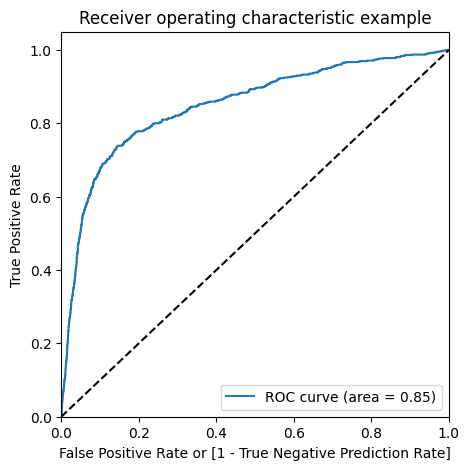

In [124]:
# ROC curve for the test dataset

# Defining the variables to plot the curve
fpr, tpr, thresholds = metrics.roc_curve(y_pred_final.churn,y_pred_final.Conv_prob, drop_intermediate = False )
# Plotting the curve for the obtained metrics
draw_roc(y_pred_final.churn,y_pred_final.Conv_prob)

### The AUC score for train dataset is 0.86 and the test dataset is 0.85.
## This model can be considered as a good model.

# PCA

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=10)

In [126]:
X_train.shape

(24000, 45)

In [127]:
from sklearn.decomposition import PCA

In [128]:
pca = PCA(random_state=42)

In [129]:
pca.fit(X_train)

PCA(random_state=42)

In [130]:
pca.components_

array([[ 9.99999997e-01,  0.00000000e+00,  2.57512443e-05, ...,
        -6.88895728e-07,  1.46651979e-05,  2.16866420e-05],
       [ 3.48411703e-05,  1.66533454e-16,  4.74869519e-02, ...,
         4.15710951e-03,  3.19833710e-05,  3.74511611e-02],
       [-4.44334607e-05, -1.11022302e-16,  4.26819261e-01, ...,
         8.68309259e-04,  6.86673383e-06,  3.82928123e-01],
       ...,
       [ 3.28929825e-10,  1.83436171e-12,  2.39342108e-05, ...,
         5.18901524e-05,  4.99178845e-05, -1.90558087e-05],
       [-9.69465737e-10, -4.47549177e-12, -1.73143166e-04, ...,
        -1.22774299e-04,  8.77521854e-06,  1.67599567e-04],
       [-0.00000000e+00,  1.00000000e+00,  9.99200722e-16, ...,
        -6.34561848e-15, -3.57214258e-14, -7.99360578e-15]])

In [131]:
from sklearn.decomposition import IncrementalPCA

In [132]:
pca_final = IncrementalPCA(n_components=16)

In [133]:
df_train_pca = pca_final.fit_transform(X_train)

In [134]:
df_train_pca.shape

(24000, 16)

In [135]:
corrmat = np.corrcoef(df_train_pca.transpose())

In [136]:
corrmat.shape

(16, 16)

In [137]:
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(6001, 16)

## Decision Tree with PCA

In [138]:
from sklearn.tree import DecisionTreeClassifier

In [139]:
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus
import graphviz


In [140]:
dt = DecisionTreeClassifier(random_state=42)

In [141]:
from sklearn.model_selection import GridSearchCV

In [142]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'min_samples_split': [50, 150, 50]
}

In [143]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [144]:
grid_search.fit(df_train_pca, y_train)

Fitting 4 folds for each of 75 candidates, totalling 300 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'min_samples_split': [50, 150, 50]},
             scoring='accuracy', verbose=1)

In [145]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.277534,0.021397,0.000000,0.000000,2,5,50,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.917833,0.917833,0.917667,0.917667,0.91775,0.000083,13
1,0.284763,0.017986,0.004411,0.007640,2,5,150,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.917833,0.917833,0.917667,0.917667,0.91775,0.000083,13
2,0.324851,0.010727,0.003904,0.006762,2,5,50,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.917833,0.917833,0.917667,0.917667,0.91775,0.000083,13
3,0.270221,0.006972,0.003907,0.006767,2,10,50,"{'max_depth': 2, 'min_samples_leaf': 10, 'min_...",0.917833,0.917833,0.917667,0.917667,0.91775,0.000083,13
4,0.246453,0.006781,0.005967,0.006707,2,10,150,"{'max_depth': 2, 'min_samples_leaf': 10, 'min_...",0.917833,0.917833,0.917667,0.917667,0.91775,0.000083,13


In [146]:
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
39,0.733454,0.017008,0.007813,0.007813,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.920167,0.918333,0.918333,0.918,0.918708,0.000853,1
41,0.746968,0.007817,0.003005,0.005205,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.920167,0.918333,0.918333,0.918,0.918708,0.000853,1
40,0.751998,0.004490,0.006280,0.006689,5,50,150,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.918667,0.918333,0.918833,0.918,0.918458,0.000320,3
33,0.747931,0.009500,0.007914,0.007915,5,10,50,"{'max_depth': 5, 'min_samples_leaf': 10, 'min_...",0.919667,0.918333,0.917667,0.918,0.918417,0.000759,4
35,0.767830,0.027913,0.012086,0.007003,5,10,50,"{'max_depth': 5, 'min_samples_leaf': 10, 'min_...",0.919667,0.918333,0.917667,0.918,0.918417,0.000759,4


In [147]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50,
                       random_state=42)

In [148]:
dt_best = DecisionTreeClassifier( random_state = 42,
                                  max_depth=10, 
                                  min_samples_leaf=20,
                                  min_samples_split=50)

In [149]:
dt_best.fit(df_train_pca, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=50,
                       random_state=42)

In [150]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [151]:
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(df_train_pca)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(df_train_pca)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(df_test_pca)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(df_test_pca)))

In [152]:
evaluate_model(dt_best)

Train Accuracy : 0.9319583333333333
Train Confusion Matrix:
[[21679   347]
 [ 1286   688]]
--------------------------------------------------
Test Accuracy : 0.9160139976670555
Test Confusion Matrix:
[[5397  137]
 [ 367  100]]


##  Random Forest with PCA

In [153]:
from sklearn.ensemble import RandomForestClassifier

In [154]:
rf = RandomForestClassifier(n_estimators=10, max_depth=4, max_features=5, random_state=100, oob_score=True)

In [155]:
rf.fit(df_train_pca, y_train)

RandomForestClassifier(max_depth=4, max_features=5, n_estimators=10,
                       oob_score=True, random_state=100)

In [156]:
rf.oob_score_

0.9173333333333333

In [157]:
# from sklearn.metrics import plot_roc_curve

from sklearn.metrics import RocCurveDisplay

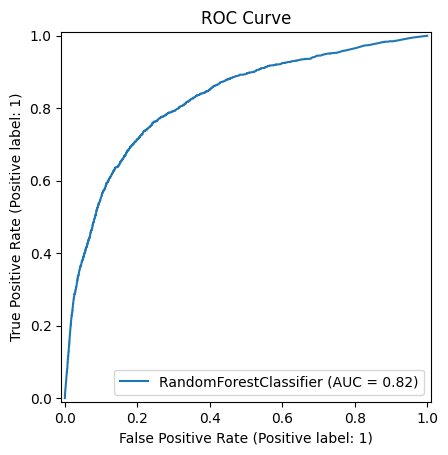

In [158]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Assuming rf is your trained model, df_train_pca is your feature data, and y_train is your target data

# Create the ROC curve display from the estimator
RocCurveDisplay.from_estimator(rf, df_train_pca, y_train)

# Show the plot
plt.title('ROC Curve')
plt.show()


### Hyper-parameter tuning for the Random Forest

In [159]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [160]:
params = {
    'max_depth': [2,3,5],
    'min_samples_leaf': [50,100],
    'min_samples_split': [ 100, 150, ],
    'n_estimators': [100, 200 ]
}

In [161]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [162]:
grid_search.fit(df_train_pca, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5], 'min_samples_leaf': [50, 100],
                         'min_samples_split': [100, 150],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [163]:
grid_search.best_score_

0.9177499999999998

In [164]:
grid_search.best_params_

{'max_depth': 2,
 'min_samples_leaf': 50,
 'min_samples_split': 100,
 'n_estimators': 100}

In [165]:
rfc_model = RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=50, 
                             min_samples_split=100,
                             n_estimators=200)

In [166]:
rfc_model.fit(df_train_pca, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=100,
                       n_estimators=200)

In [167]:
evaluate_model(rfc_model)

Train Accuracy : 0.91775
Train Confusion Matrix:
[[22026     0]
 [ 1974     0]]
--------------------------------------------------
Test Accuracy : 0.9221796367272121
Test Confusion Matrix:
[[5534    0]
 [ 467    0]]


### Note:
The best parameters produced an accuracy of 91%, which is not significantly different from the original random forest accuracy of 92%.

### Conclusion:
The best model for predicting churn is observed to be the Random Forest, based on its accuracy performance measure.

Incoming calls (local same operator mobile, other operator mobile, fixed lines, STD, or Special) play a vital role in understanding the possibility of churn. Therefore, the operator should focus on incoming calls data and consider providing special offers to customers whose incoming calls are decreasing.

### Details:
After cleaning the data, we employed three main models, each with variations, to determine the best model in each case:

Logistic Regression:

Logistic Regression with RFE

Decision Tree with PCA:

Train Accuracy: ~93%
Test Accuracy: ~91%

Random Forest with PCA:

Train Accuracy: ~91%
Test Accuracy: ~92%

### Performance Summary:

Logistic Regression:

Train Accuracy: ~79%
Test Accuracy: ~81%

Decision Tree with PCA:

Train Accuracy: ~93%
Test Accuracy: ~91%

Random Forest with PCA:

Train Accuracy: ~91%
Test Accuracy: ~92%